In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from analysis.timepoint_analysis import sample_signals_and_metrics, sample_low_and_high_signals
from config import all_brain_regions, all_event_types, all_metrics
from itertools import product
import numpy as np
from utils import mouse_br_events_count

from fitsne import FItSNE
import matplotlib.pyplot as plt

window_size = 5
window = np.ones(window_size) / window_size

sessions = load_and_prepare_sessions("../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)
mouse_analyser = MiceAnalysis(sessions)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
# generate all aggregated signals
all_event_signals = []
labels = []

for mouse in mouse_analyser.mice_dict.values():
    mouse_sessions = mouse.sessions
    for brain_region, event in product(all_brain_regions, all_event_types):
        if mouse_br_events_count(mouse, brain_region, event) < 15:
            continue
        if brain_region != 'VS':
            continue
        if event == 'cor_reject':
            continue
        # if brain_region == 'cor_reject':
        #     continue
        mouse_signals = [] 
        for session in mouse_sessions:
            if session.signal_info.get((brain_region, event)) is None:
                continue
            signals = sample_signals_and_metrics([session], event, brain_region)[0]
            signals = np.array([np.convolve(signal, window, mode='same') for signal in signals])
            mouse_signals.append(signals[:, 150:250])
        if len(mouse_signals) == 0:
            continue
        mouse_signals = np.vstack(mouse_signals)
        sample_idxs = np.random.choice(len(mouse_signals), 100, replace=True)
        mouse_signals = mouse_signals[sample_idxs]

        # Cumulative events data for the current metric
        part_value = mouse.metric_container.data['participation']
        if len(mouse_signals) > 5:
            for i in range(5):
                all_event_signals.append(np.mean(mouse_signals[i::5], axis=0))
                labels.append((mouse.mouse_id, brain_region, event, part_value))
        # all_event_signals.append(mouse_signals)
        # labels.extend([(mouse.mouse_id, brain_region, event, part_value)] * len(mouse_signals))

all_event_signals = np.array(all_event_signals)
# all_event_signals = np.vstack(all_event_signals)

In [6]:
signals_embedded = FItSNE(all_event_signals, max_iter=750);

Will use momentum during exaggeration phase
Computing input similarities...
Using perplexity, so normalizing input data (to prevent numerical problems)
Using perplexity, not the manually set kernel width.  K (number of nearest neighbors) and sigma (bandwidth) parameters are going to be ignored.
Using ANNOY for knn search, with parameters: n_trees 50 and search_k 4500
Going to allocate memory. N: 185, K: 90, N*K = 16650
Building Annoy tree...
Done building tree. Beginning nearest neighbor search... 
parallel (8 threads):
[============================================================] 100% 0.005s
Symmetrizing...
Using the given initialization.
Exaggerating Ps by 12.000000
Input similarities computed (sparsity = 0.616625)!
Learning embedding...
Using FIt-SNE approximation.
Iteration 50 (50 iterations in 0.23 seconds), cost 1.486397
Iteration 100 (50 iterations in 0.21 seconds), cost 1.438349
Iteration 150 (50 iterations in 0.21 seconds), cost 1.507607
Iteration 200 (50 iterations in 0.21 s

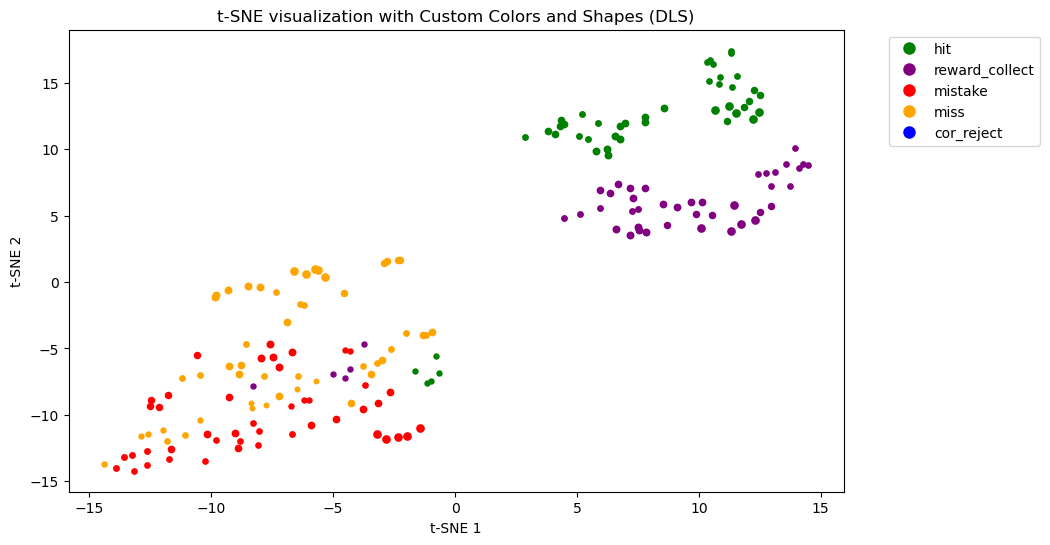

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define mappings
colors = {'hit': 'green', 
        'reward_collect': 
        'purple', 'mistake': 
        'red', 'miss':'orange', 
        'cor_reject':'blue'}

shapes = {'DMS': 'o', 'DLS': 's', 'VS': 'o'}

brain_reg_to_color = {'VS': 'purple',
                      'DMS': 'forestgreen',
                      'DLS': 'C0'}

max_participation = max([label[-1] for label in labels])
labels = [(label[0], label[1], label[2], label[3] / max_participation) for label in labels]

plt.figure(figsize=(10, 6))

# Iterate over each point to plot
for point, label in zip(signals_embedded, labels):
    color = colors[label[2]]
    # color = brain_reg_to_color[label[1]]
    shape = shapes[label[1]]
    plt.scatter(point[0], point[1], c=color, marker=shape, s=np.exp(label[-1])*10)

# Create custom legends
from matplotlib.lines import Line2D
color_legend = [Line2D([0], [0], marker='o', color='w', label=key, 
                    markerfacecolor=val, markersize=10) for key, val in colors.items()]

# Display legends
plt.legend(handles=color_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f't-SNE visualization with Custom Colors and Shapes ({brain_region})')
plt.show()